In [1]:
import numpy as np
import pylab as plt

import sys
sys.path.append('../scripts')
import emission_line_model as elm

from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


In [2]:
lines = ["OII_DOUBLET", "HGAMMA", "HBETA", "OIII_4959", "OIII_5007", "NII_6548",\
         "HALPHA", "NII_6584", "SII_6716", "SII_6731"]
lines_names = [r'[O II] $\lambda3727 + \lambda3729$', r'$H\gamma$ $\lambda$4342', r'$H\beta$ $\lambda$4863', r'[O III] $\lambda$4969', '[O III] $\lambda$5007', \
               '[N II] $\lambda$6548', r'$H\alpha$ $\lambda$6564', '[N II] $\lambda$6584', '[S II] $\lambda$6716', '[S II] $\lambda$6731']

model = elm.EmissionLineModel(path_to_model='../models/params_of_model_with_luminosity.npy')


I0000 00:00:1742788835.399773       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Text(0.05, 0.5, 'Counts')

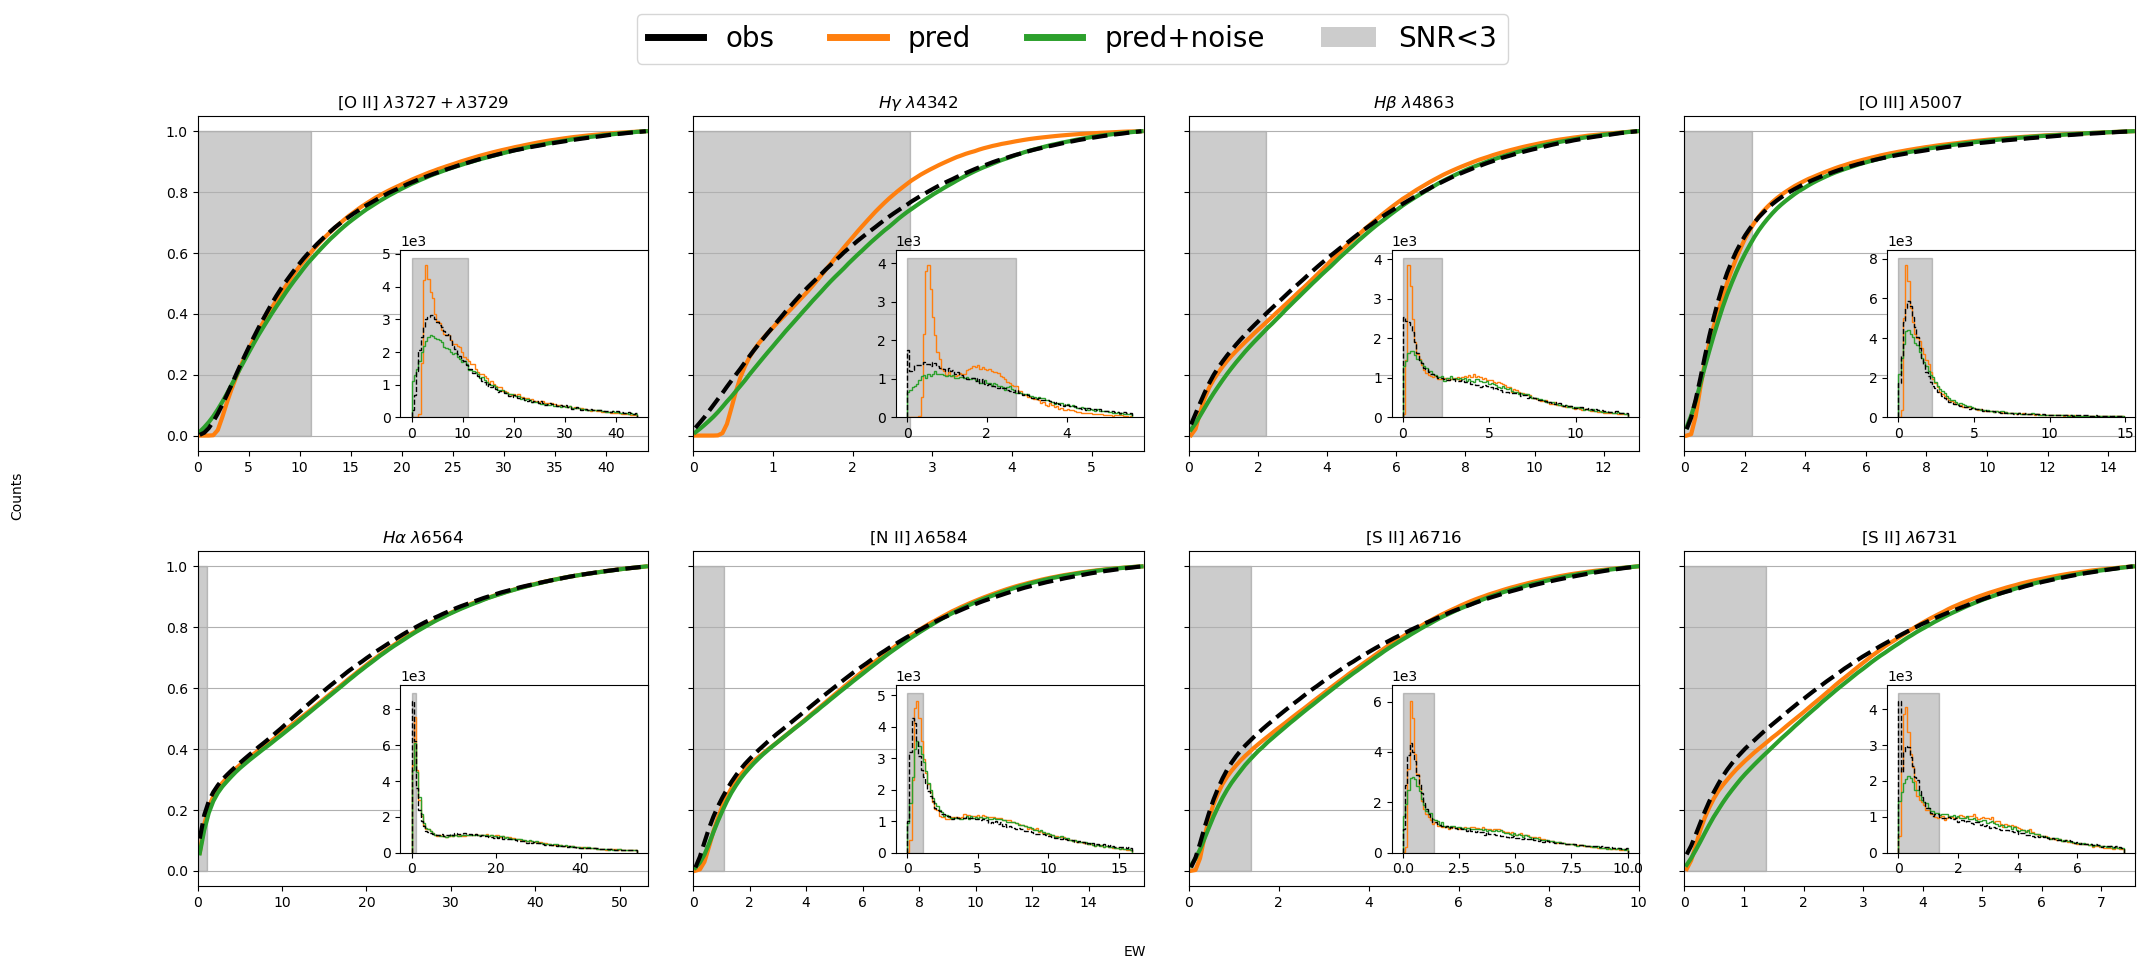

In [3]:
ll = [[0,1,2,4],[6,7,8,9]]
n_bins = 100
lw = 1

fig, ax = plt.subplots(figsize=(25,10), nrows=2, ncols=4, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
for i in range(2):
    for j in range(4):
        l = ll[i][j]
        obs_ews = np.load('../data/test_set_ews_'+lines[l]+'.npy')
        obs_ew_ivars = np.load('../data/test_set_ew_ivars_'+lines[l]+'.npy')
        obs_continuum_colors = np.load('../data/test_set_continuum_colors_'+lines[l]+'.npy')
        obs_continuum_luminosities = np.load('../data/test_set_continuum_luminosities_'+lines[l]+'.npy')

        pred_ews = model.predict(colors=obs_continuum_colors, luminosities=obs_continuum_luminosities)[lines[l]]
        pred_ews_noisy = np.random.normal(pred_ews, 1/np.sqrt(obs_ew_ivars))

        spearman = stats.spearmanr(obs_ews, pred_ews)[0]
        nmad = 1.48*np.median(np.abs(obs_ews-pred_ews))
        bias = np.median(pred_ews/obs_ews)
        
        inset_ax = ax[i,j].inset_axes([0.45, 0.1, 0.55, 0.5])
        inset_ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        hist_fit = inset_ax.hist(pred_ews, bins=n_bins, range=(0,np.quantile(obs_ews,0.95)), color='tab:orange', alpha=1, histtype='step', label='pred', linewidth=lw)
        hist_fit_noisy = inset_ax.hist(pred_ews_noisy, bins=n_bins, range=(0,np.quantile(obs_ews,0.95)), color='tab:green', alpha=1, histtype='step', label='pred noisy', linewidth=lw)
        hist_obs = inset_ax.hist(obs_ews, bins=n_bins, range=(0,np.quantile(obs_ews,0.95)), color='k', alpha=1, histtype='step', label='obs', linewidth=lw, linestyle='dashed')
        
        # Get signal-to-noise ratio as a function of EW to plot the SNR<3 region
        snr = stats.binned_statistic(obs_ews, obs_ews*np.sqrt(obs_ew_ivars), bins=n_bins, range=np.quantile(obs_ews,(0.0,0.95)), statistic='mean')
        bin_centers = 0.5*(snr[1][1:]+snr[1][:-1])
        snr_lim = np.interp(3, snr[0], bin_centers)
        ax[i,j].fill_between([0, snr_lim], 0, 1, color='black', alpha=0.2)
        inset_ax.fill_between([0, snr_lim], 0, inset_ax.get_ylim()[1], color='black', alpha=0.2)

        # Plot the cumulative distribution
        obs_cumsum = np.cumsum(hist_obs[0])
        fit_cumsum = np.cumsum(hist_fit[0])
        fit_noisy_cumsum = np.cumsum(hist_fit_noisy[0])

        ax[i,j].plot(0.5*(hist_fit[1][:-1]+hist_fit[1][1:]), fit_cumsum/fit_cumsum[-1], color='tab:orange', lw=3)
        ax[i,j].plot(0.5*(hist_fit_noisy[1][:-1]+hist_fit_noisy[1][1:]), fit_noisy_cumsum/fit_noisy_cumsum[-1], color='tab:green', lw=3)
        ax[i,j].plot(0.5*(hist_obs[1][:-1]+hist_obs[1][1:]), obs_cumsum/obs_cumsum[-1], color='k', linestyle='dashed', lw=3)

        ax[i,j].set_xlim(0, np.quantile(obs_ews,(0.01,0.95))[1])
        ax[i,j].grid(axis='y')
        ax[i,j].set_title(lines_names[l])

legend_elements = [Line2D([0],[0], color='k', alpha=1, linewidth=5, ls='-', label='obs'),
                   Line2D([0],[0], color='tab:orange', alpha=1, linewidth=5, ls='-', label='pred'),
                   Line2D([0],[0], color='tab:green', linewidth=5, ls='-', label='pred+noise'),
                   Patch(facecolor='black', alpha=0.2, label='SNR<3')]

leg = fig.legend(handles=legend_elements, loc='upper center', prop={'size': 20}, ncol=len(legend_elements))

fig.text(0.5, 0.04, r'EW', ha='center')
fig.text(0.05, 0.5, r'Counts', va='center', rotation='vertical')